# Wine Quality

In this notebook, we would like to build a model that assigns a score to a wine according to its physicochemical attributes. The dataset can be downloaded from [kaggle](https://www.kaggle.com/yasserh/wine-quality-dataset) or from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/wine+quality).

In [1]:
!pip install imblearn 

In [2]:
! pip install -U ibm-watson-machine-learning

In [3]:
#Libraries

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3
from ibm_watson_machine_learning import APIClient
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

## 0. Dataset

First we will load the dataset.

In [4]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_042f6a05e0c6481fa99095b13fe64cf0 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Oe5xHin8a99c0nXmnT30STyRvgKQAlhYfv_H73KqP1_w',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu.cloud-object-storage.appdomain.cloud')

body = client_042f6a05e0c6481fa99095b13fe64cf0.get_object(Bucket='winequality-donotdelete-pr-d8vrwfdgu0zacr',Key='WineQT.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

wine_df = pd.read_csv(body, index_col="Id")
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Now, we will do an exploratory data analysis (EDA), to gather first insights and determine the model steps. 

In [5]:
wine_df.info() #there are no missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143 entries, 0 to 1597
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 116.1 KB


In [6]:
#Let us see the distribution of our data
#Classes are very unbalanced
wine_df["quality"].value_counts()

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


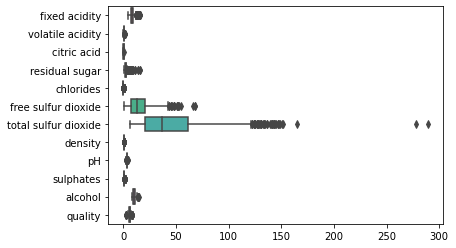

In [7]:
sns.boxplot(data=wine_df, orient="h")
wine_df.describe()

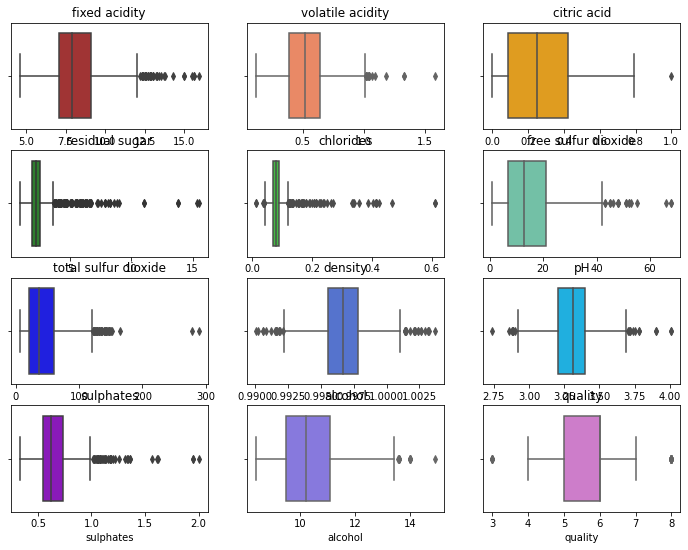

In [8]:
boxplot_colors = ["firebrick", "coral", "orange", "forestgreen", "limegreen", "mediumaquamarine",
                  "blue", "royalblue", "deepskyblue","darkviolet", "mediumslateblue", "orchid"]

fig, axs = plt.subplots(4, 3, figsize=(12,9))

v=0
for i in np.arange(4):
    for j in np.arange(3):
        sns.boxplot(x=wine_df[wine_df.columns[j+v]], ax=axs[i,j], color=boxplot_colors[j+v])
        axs[i,j].set_title(wine_df.columns[j+v])
    v=v+3

<AxesSubplot:>

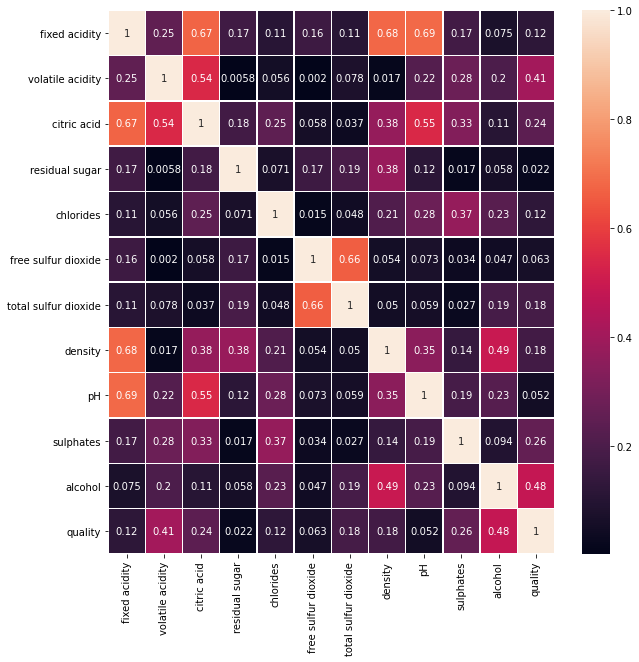

In [9]:
#Analyze correlation between numerical variables
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(wine_df.corr().abs(), annot=True, linewidths=0.5, ax=ax)

In [10]:
#grouping data to see if we observe significant differences between classes
wine_df.groupby(["quality"]).median()

#volatile acidity, sulphates, citric acid and fixed acidity are ordered. This may suggest that these variables have an influence on the ranking. 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,7.45,0.8175,0.050,2.1,0.0800,5.5,15.0,0.997565,3.355,0.56,9.825
4,7.60,0.6750,0.070,2.1,0.0780,12.0,32.0,0.996640,3.380,0.56,10.000
5,7.80,0.5900,0.230,2.2,0.0810,14.0,46.0,0.996920,3.300,0.58,9.700
6,7.90,0.5000,0.245,2.2,0.0785,14.0,35.0,0.996520,3.320,0.64,10.500
7,8.70,0.3600,0.400,2.3,0.0730,12.0,28.0,0.995680,3.270,0.74,11.600
8,8.85,0.3550,0.455,2.1,0.0715,6.5,18.0,0.995580,3.225,0.73,11.750


## 1. Build a Model

We will build a Random Forest Classifier. We will compare two metrics: accuracy and precision. 

* precision = tp / (tp + fp)
* accuracy = (tp + tn) / (tp + tn + fp + fn) 

In [11]:
#define X and y
X = wine_df.iloc[:,:-1].to_numpy()
y = wine_df["quality"].to_numpy()

#test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("test data:", np.unique(y_test.flatten(), return_counts=True))
print("train data:" ,np.unique(y_train.flatten(), return_counts=True))

test data: (array([3, 4, 5, 6, 7, 8]), array([  2,   9, 151, 137,  41,   3]))
train data: (array([3, 4, 5, 6, 7, 8]), array([  4,  24, 332, 325, 102,  13]))


In [12]:
#define the model
forest = RandomForestClassifier(random_state=0)

#fit the model
forest.fit(X_train,y_train)

#compute predictions
predictions_test = forest.predict(X_test)
predictions_train = forest.predict(X_train)
predictions_original = forest.predict(X)

#compute accuracy
accuracy_test = accuracy_score(y_test, predictions_test)
accuracy_train = accuracy_score(y_train, predictions_train)
accuracy_original = accuracy_score(y, predictions_original)

#compute precision
precision_test = precision_score(y_test, predictions_test, average='macro', zero_division=0)
precision_train = precision_score(y_train, predictions_train, average='macro', zero_division=0)
precision_original = precision_score(y, predictions_original, average='macro', zero_division=0)

print("accuracy for train data:", accuracy_train)
print("accuracy for test data:", accuracy_test)
print("accuracy for original data:", accuracy_original)
print(" ")
print("precision for train data:", precision_train)
print("precision for test data:", precision_test)
print("precision for original data:", precision_original)

accuracy for train data: 1.0
accuracy for test data: 0.6530612244897959
accuracy for original data: 0.8958880139982502
 
precision for train data: 1.0
precision for test data: 0.3329330168039845
precision for original data: 0.9384341961104666


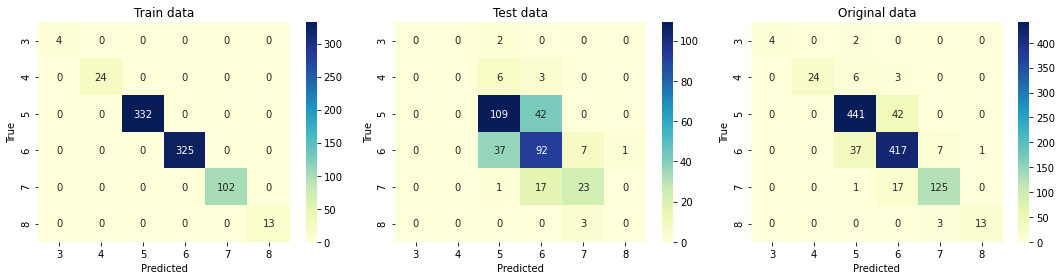

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
ax1, ax2, ax3 = axes

conf_matrix_test = confusion_matrix(y_test, predictions_test)
conf_matrix_train = confusion_matrix(y_train, predictions_train)
conf_matrix_original = confusion_matrix(y, predictions_original)

s1 = sns.heatmap(conf_matrix_train, annot=True, cmap="YlGnBu", fmt="d", xticklabels=np.arange(6) + 3, yticklabels=np.arange(6) + 3, ax=ax1)
s2 = sns.heatmap(conf_matrix_test, annot=True, cmap="YlGnBu", fmt="d", xticklabels=np.arange(6) + 3, yticklabels=np.arange(6) + 3, ax=ax2)
s3 = sns.heatmap(conf_matrix_original, annot=True, cmap="YlGnBu", fmt="d", xticklabels=np.arange(6) + 3, yticklabels=np.arange(6) + 3, ax=ax3)

s1.set(xlabel='Predicted', ylabel='True', title="Train data")
s2.set(xlabel='Predicted', ylabel='True', title="Test data")
s3.set(xlabel='Predicted', ylabel='True', title="Original data")

fig.tight_layout()

<AxesSubplot:xlabel='importance', ylabel='feature'>

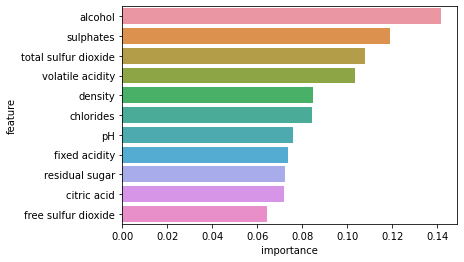

In [14]:
importance_df = pd.DataFrame({"feature": wine_df.iloc[:,:-1].columns, "importance": forest.feature_importances_}).sort_values(by="importance", ascending=False)
sns.barplot(data=importance_df, y="feature", x="importance")

## 1. Data Preprocessing

We will train a Random Forest Classifier and use an oversampling technique called **SMOTE**. SMOTE (Synthetic Minority Oversampling Technique)is a way of generate synthetic data from underrepresented classes using k-nearest neighbors as it follows:
1. Choose a sample z of an underrepresented class
2. Find the k-nearest neighbors of z (k is an hyperparameter, default k=5) 
3. Choose one of the neighbors and place a point randomly on the line between z and this neighbor
4. Repeat until data is balanced

[source](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

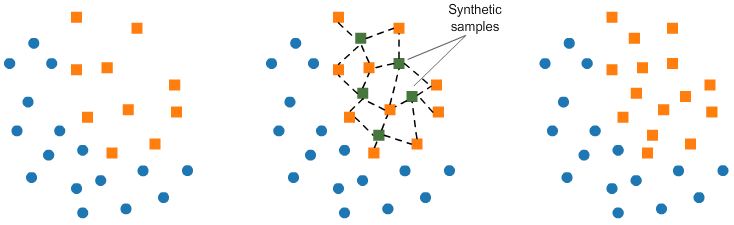

In [15]:
#SMOTE algorithm
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)
print('Original dataset shape', np.unique(y.flatten(), return_counts=True))
print('Resample dataset shape', np.unique(y_smote.flatten(), return_counts=True))

Original dataset shape (array([3, 4, 5, 6, 7, 8]), array([  6,  33, 483, 462, 143,  16]))
Resample dataset shape (array([3, 4, 5, 6, 7, 8]), array([483, 483, 483, 483, 483, 483]))


In [16]:
#test-train split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=0)
print("test data:", np.unique(y_test.flatten(), return_counts=True))
print("train data:" ,np.unique(y_train.flatten(), return_counts=True))

test data: (array([3, 4, 5, 6, 7, 8]), array([140, 132, 151, 153, 149, 145]))
train data: (array([3, 4, 5, 6, 7, 8]), array([343, 351, 332, 330, 334, 338]))


## 2. Train the model

For showing purposes, we will only train a random forest classifier.  

In [17]:
#define the model
forest = RandomForestClassifier(random_state=0)

#fit the model
forest.fit(X_train,y_train)

#compute predictions
predictions_test = forest.predict(X_test)
predictions_train = forest.predict(X_train)
predictions_original = forest.predict(X)

#compute accuracy
accuracy_test = accuracy_score(y_test, predictions_test)
accuracy_train = accuracy_score(y_train, predictions_train)
accuracy_original = accuracy_score(y, predictions_original)

#compute precision
precision_test = precision_score(y_test, predictions_test, average='macro', zero_division=0)
precision_train = precision_score(y_train, predictions_train, average='macro', zero_division=0)
precision_original = precision_score(y, predictions_original, average='macro', zero_division=0)

print("accuracy for train data:", accuracy_train)
print("accuracy for test data:", accuracy_test)
print("accuracy for original data:", accuracy_original)
print(" ")
print("precision for train data:", precision_train)
print("precision for test data:", precision_test)
print("precision for original data:", precision_original)

accuracy for train data: 1.0
accuracy for test data: 0.8264367816091954
accuracy for original data: 0.8853893263342082
 
precision for train data: 1.0
precision for test data: 0.8206046642538802
precision for original data: 0.8002308665401645


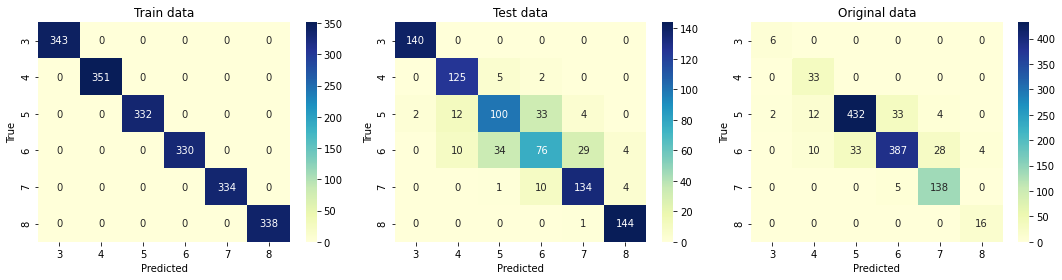

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
ax1, ax2, ax3 = axes

conf_matrix_test = confusion_matrix(y_test, predictions_test)
conf_matrix_train = confusion_matrix(y_train, predictions_train)
conf_matrix_original = confusion_matrix(y, predictions_original)

s1 = sns.heatmap(conf_matrix_train, annot=True, cmap="YlGnBu", fmt="d", xticklabels=np.arange(6) + 3, yticklabels=np.arange(6) + 3, ax=ax1)
s2 = sns.heatmap(conf_matrix_test, annot=True, cmap="YlGnBu", fmt="d", xticklabels=np.arange(6) + 3, yticklabels=np.arange(6) + 3, ax=ax2)
s3 = sns.heatmap(conf_matrix_original, annot=True, cmap="YlGnBu", fmt="d", xticklabels=np.arange(6) + 3, yticklabels=np.arange(6) + 3, ax=ax3)

s1.set(xlabel='Predicted', ylabel='True', title="Train data")
s2.set(xlabel='Predicted', ylabel='True', title="Test data")
s3.set(xlabel='Predicted', ylabel='True', title="Original data")

fig.tight_layout()

<AxesSubplot:xlabel='importance', ylabel='feature'>

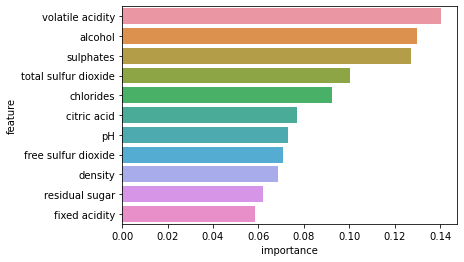

In [19]:
importance_df = pd.DataFrame({"feature": wine_df.iloc[:,:-1].columns, "importance": forest.feature_importances_}).sort_values(by="importance", ascending=False)
sns.barplot(data=importance_df, y="feature", x="importance")

## 3. Deploy the model

In order to deploy the model, we need to create an API Key using our IBM Cloud account and a deployment space linked with our machine learning service.

We can also create an online deployment to use the model as a web service. See [notebook](https://github.com/IBM/watson-studio-learning-path-assets/blob/master/examples/customer-churn-kaggle-with-output.ipynb).

In [20]:
api_key = "wKyjdyMmW2742MjPiiwhjK_2ZR0zhw7XgmCpyrtQIli1"
location = "eu-de"

vml_credentials = {"apikey": api_key, "url": "https://" + location + ".ml.cloud.ibm.com"}
client = APIClient(vml_credentials)
print(client.version)

1.0.181


In [21]:
vml_credentials

{'apikey': 'wKyjdyMmW2742MjPiiwhjK_2ZR0zhw7XgmCpyrtQIli1',
 'url': 'https://eu-de.ml.cloud.ibm.com'}

In [22]:
space_id = "dd149bb7-38bb-4732-b6fd-db92f656b673"
client.spaces.list(limit=10)

------------------------------------  ---------------------  ------------------------
ID                                    NAME                   CREATED
dd149bb7-38bb-4732-b6fd-db92f656b673  checkride-deployment   2022-02-10T14:10:03.321Z
cff0d890-2822-45ec-ac04-10a09b082c55  Payment Plan campaign  2022-01-19T12:30:33.742Z
------------------------------------  ---------------------  ------------------------


In [23]:
client.set.default_space(space_id)

'SUCCESS'

### Upload model

In [24]:
sofware_spec_uid = client.software_specifications.get_id_by_name("default_py3.8")

metadata = {client.repository.ModelMetaNames.NAME: 'Random Forest to rank wine',
            #client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid}

#published_model = client.repository.store_model(model=forest, meta_props=metadata)

In [25]:
published_model = client.repository.store_model(model=forest, meta_props=metadata)

Failure during scoring. (POST https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/825acdaa-3f42-4012-84e1-10056d395389/predictions?version=2021-06-24)
Status code: 400, body: {"trace": "3344f613b96ac3f0844b93e299d5626e", "errors": [{"code": "score_processing_failure", "message": "'DecisionTreeClassifier' object has no attribute 'n_features_'"}], "status_code": 400}

Failure during scoring. (POST https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/825acdaa-3f42-4012-84e1-10056d395389/predictions?version=2021-06-24)
Status code: 400, body: {"trace": "1b0d3546d212b394e4735b6791a1c3ce", "errors": [{"code": "score_processing_failure", "message": "'DecisionTreeClassifier' object has no attribute 'n_features_'"}], "status_code": 400}

Failure during scoring. (POST https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/825acdaa-3f42-4012-84e1-10056d395389/predictions?version=2021-06-24)
Status code: 400, body: {"trace": "9c65c072eeb13c75a3c988dfaacf1bab", "errors": [{"code": "invalid_input_data", "message

In [26]:
# Get model details
import json

published_model_uid = client.repository.get_model_id(published_model)
model_details = client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "hybrid_pipeline_software_specs": [],
    "software_spec": {
      "id": "ab9e1b80-f2ce-592c-a7d2-4f2344f77194",
      "name": "default_py3.8"
    },
    "type": "scikit-learn_0.23"
  },
  "metadata": {
    "created_at": "2022-02-10T15:47:01.626Z",
    "id": "65268fc2-015b-407c-b2ac-245d1e5be116",
    "modified_at": "2022-02-10T15:47:06.939Z",
    "name": "Random Forest to rank wine",
    "owner": "IBMid-663002Z5HL",
    "resource_key": "61a83da6-1b62-4e15-a726-6623f6bedfd3",
    "space_id": "dd149bb7-38bb-4732-b6fd-db92f656b673"
  },
  "system": {
    "warnings": []
  }
}


In [27]:
client.repository.list_models()

------------------------------------  --------------------------  ------------------------  -----------------
ID                                    NAME                        CREATED                   TYPE
65268fc2-015b-407c-b2ac-245d1e5be116  Random Forest to rank wine  2022-02-10T15:47:01.002Z  scikit-learn_0.23
a9364b96-75d2-43f6-a186-370e9dfde293  Random Forest to rank wine  2022-02-10T15:24:59.002Z  scikit-learn_0.23
------------------------------------  --------------------------  ------------------------  -----------------


In [28]:
#to delete models. the argument is the model ID. Always erase the oldest

#client.repository.delete("a9364b96-75d2-43f6-a186-370e9dfde293")

'SUCCESS'

In [29]:
client.repository.list_models()

------------------------------------  --------------------------  ------------------------  -----------------
ID                                    NAME                        CREATED                   TYPE
65268fc2-015b-407c-b2ac-245d1e5be116  Random Forest to rank wine  2022-02-10T15:47:01.002Z  scikit-learn_0.23
------------------------------------  --------------------------  ------------------------  -----------------


### Create Online Deployment

In [30]:
# Create online deployment
metadata = {client.deployments.ConfigurationMetaNames.NAME: "Deployment of wine ranking model",
            client.deployments.ConfigurationMetaNames.ONLINE: {}}

created_deployment = client.deployments.create(published_model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '65268fc2-015b-407c-b2ac-245d1e5be116' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='825acdaa-3f42-4012-84e1-10056d395389'
------------------------------------------------------------------------------------------------




In [31]:
# Get deployment UID and show details on the deployment
deployment_uid = client.deployments.get_uid(created_deployment)
client.deployments.get_details(deployment_uid)

Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.


{'entity': {'asset': {'id': '65268fc2-015b-407c-b2ac-245d1e5be116'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'e7ed1d6c-2e89-42d7-aed5-863b972c1d2b',
   'name': 'S',
   'num_nodes': 1},
  'name': 'Deployment of wine ranking model',
  'online': {},
  'space_id': 'dd149bb7-38bb-4732-b6fd-db92f656b673',
  'status': {'online_url': {'url': 'https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/825acdaa-3f42-4012-84e1-10056d395389/predictions'},
   'serving_urls': ['https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/825acdaa-3f42-4012-84e1-10056d395389/predictions'],
   'state': 'ready'}},
 'metadata': {'created_at': '2022-02-10T15:47:52.744Z',
  'id': '825acdaa-3f42-4012-84e1-10056d395389',
  'modified_at': '2022-02-10T15:47:52.744Z',
  'name': 'Deployment of wine ranking model',
  'owner': 'IBMid-663002Z5HL',
  'space_id': 'dd149bb7-38bb-4732-b6fd-db92f656b673'},
 'system': {'warnings': [{'id': 'Deprecated',
    'message': 'online_url is deprecated and will be r

In [32]:
# list all deployments
client.deployments.list()

------------------------------------  --------------------------------  -----  ------------------------
GUID                                  NAME                              STATE  CREATED
825acdaa-3f42-4012-84e1-10056d395389  Deployment of wine ranking model  ready  2022-02-10T15:47:52.744Z
------------------------------------  --------------------------------  -----  ------------------------


In [33]:
# delete old deployments
# client.deployments.delete('GUID of deployed model')

### Scoring

In [34]:
#get scoring endpoint
scoring_endpoint = client.deployments.get_scoring_href(created_deployment)
print(scoring_endpoint)

https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/825acdaa-3f42-4012-84e1-10056d395389/predictions


In [40]:
wine_df.iloc[:,:-1]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Id,,,,,,,,,,,
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1592,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5


In [64]:
wine_df.iloc[:,:-1].iloc[0,:].reset_index(drop=True)

0      7.4000
1      0.7000
2      0.0000
3      1.9000
4      0.0760
5     11.0000
6     34.0000
7      0.9978
8      3.5100
9      0.5600
10     9.4000
Name: 0, dtype: float64

In [74]:
# use our WML client to score our model
# add some test data
scoring_wine = {client.deployments.ScoringMetaNames.INPUT_DATA:[{"fields": ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                                                                            'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                                                                            'pH', 'sulphates', 'alcohol'],
                                                                 "values": [[7.4, 0.7, 0, 1.9, 0.076, 11, 34, 0.9978, 3.51, 0.56, 9.4]]}] 
                }

In [76]:
# score the model
predictions = client.deployments.score(deployment_uid, scoring_wine)
print('prediction',json.dumps(predictions, indent=2))

##the error is due to incompatibility issues, see https://www.ibm.com/docs/en/cloud-paks/cp-data/3.5.0?topic=overview-specifying-model-type-software-specification

ApiRequestFailure: Failure during scoring. (POST https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/825acdaa-3f42-4012-84e1-10056d395389/predictions?version=2021-06-24)
Status code: 400, body: {"trace": "b9d46181dafb67c009a2586c6f25dfbf", "errors": [{"code": "score_processing_failure", "message": "'DecisionTreeClassifier' object has no attribute 'n_features_'"}], "status_code": 400}
